# 1. Loading Data

## Load data from CSV

In [87]:
import pandas as pd
import numpy as np

data = pd.read_csv("DATA/Final.csv") # Read the CSV into jupyter
# Aggregate of 25 games used for statistics

# The areas of basketball that I want to cover in my modeling is
#    * Team Shooting: eFG%.x, FT%.x, eFG%.y, FT%.y
#    * Rebounding: ORB%.x, DRB%.x, ORB%.y, DRB%.y
#    * Ball security: TOV%.x, TOV%.y
#    * Defense: opp_eFG%.x, opp_eFG%.y, opp_TOV%.x, opp_TOV%.y
#    * Homecourt: home.x
#    * back-to-back: back_to_back.x, back_to_back.y
#    * Recent performance: win%.x, NET_rating.x, win%.y, NET_rating.y, elo.x, elo.y
# The statistics that are used in this model provide a heulistic view of an NBA game

## Observe the columns 

In [89]:
print(f"{data.columns}\n\n")

Index(['season', 'date', 'team.x', 'game_number.x', 'home.x', 'result',
       'back_to_back.x', 'eFG%.x', 'FT%.x', 'ORB%.x', 'DRB%.x', 'TOV%.x',
       'opp_eFG%.x', 'opp_TOV%.x', 'NET_rating.x', 'win%.x', 'elo.x', 'team.y',
       'game_number.y', 'back_to_back.y', 'eFG%.y', 'FT%.y', 'ORB%.y',
       'DRB%.y', 'TOV%.y', 'opp_eFG%.y', 'opp_TOV%.y', 'NET_rating.y',
       'win%.y', 'elo.y'],
      dtype='object')




## Check for null values

In [90]:
# Print if there are any cols with more than 0 missing values
print(data.isnull().sum()[data.isnull().sum() > 0])

Series([], dtype: int64)


There are no null values

# 2. Exploratory Data Analysis

In this section, we will exclude the first 5 games of the season, and only use games that occur after 2020

In [131]:
data_copy = data.copy()
data_copy['result.y'] = 1 - data_copy['result']
data_copy = data_copy[data_copy["game_number.x"] > 5]
data_copy = data_copy[data_copy["season"] >= 2020]

## a. Histograms

These histograms represent a teams averages for the given statistic in the last 25 games, and their outcome in the current game

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_grouped_histogram(df, metric_col_x, metric_col_y, result_col="result", bins=30, shrink=0.8,
                            x_label=None, title=None):
    """
    Plots a grouped histogram of a metric by result outcome using both .x and .y team data.
    """
    metric_values = pd.concat([df[metric_col_x], df[metric_col_y]], ignore_index=True)
    results = pd.concat([df[result_col], df[f"{result_col}.y"]], ignore_index=True)
    teams = [".x"] * len(df) + [".y"] * len(df)

    plot_df = pd.DataFrame({
        "Metric": metric_values,
        "Result": results.map({1: "Win", 0: "Loss"}),
        "Team": teams
    })

    # Use default label if none provided
    metric_label = x_label or metric_col_x[:-2]

    plt.figure(figsize=(10, 6))
    sns.histplot(data=plot_df, x="Metric", hue="Result", multiple="dodge", bins=bins, 
                 palette={"Win": "blue", "Loss": "red"}, shrink=shrink)
    plt.title(title or f"Grouped Histogram of {metric_label} by Game Result")
    plt.xlabel(metric_label)
    plt.ylabel("Game Count")
    plt.grid(True)
    plt.show()

### i. Net Rating

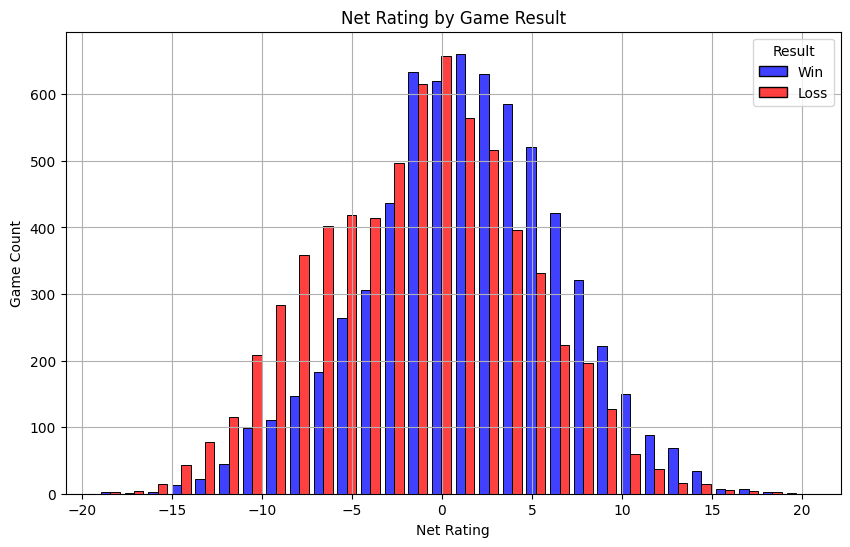

In [136]:
plot_grouped_histogram(data_copy, metric_col_x="NET_rating.x", metric_col_y="NET_rating.y", bins=30,
    x_label="Net Rating",title="Net Rating by Game Result")

### ii. eFG%

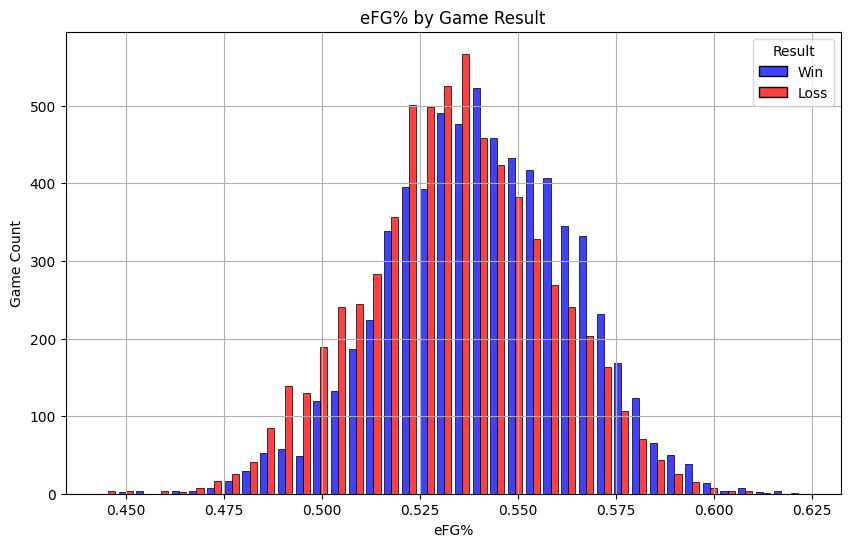

In [137]:
plot_grouped_histogram(data_copy, metric_col_x="eFG%.x", metric_col_y="eFG%.y", bins=40,
    x_label="eFG%", title="eFG% by Game Result")

### iii) Unused plots

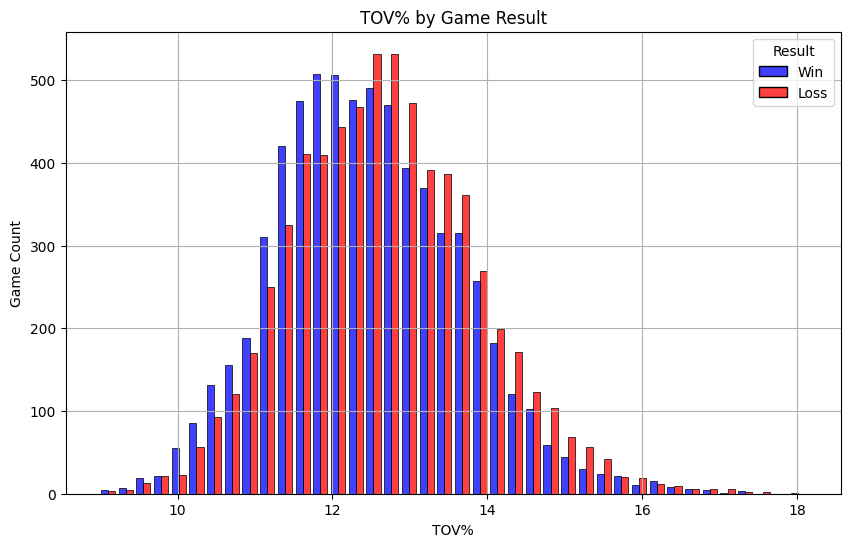

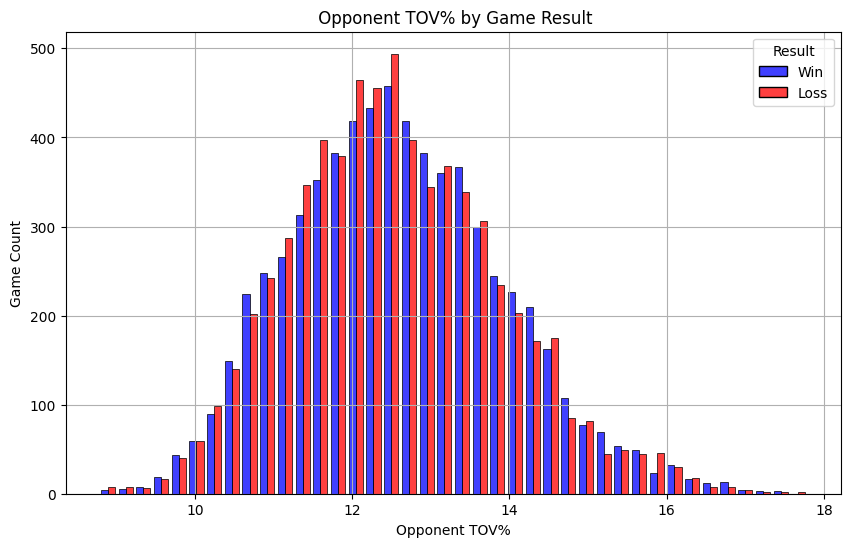

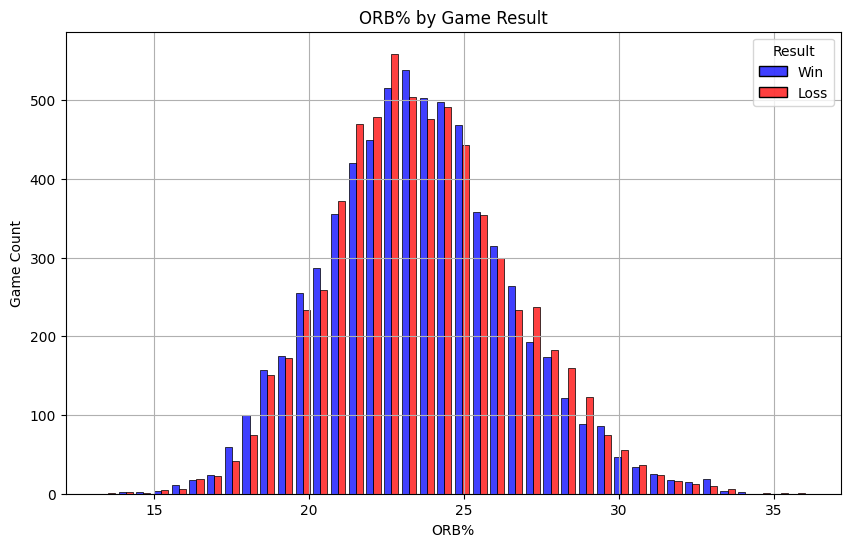

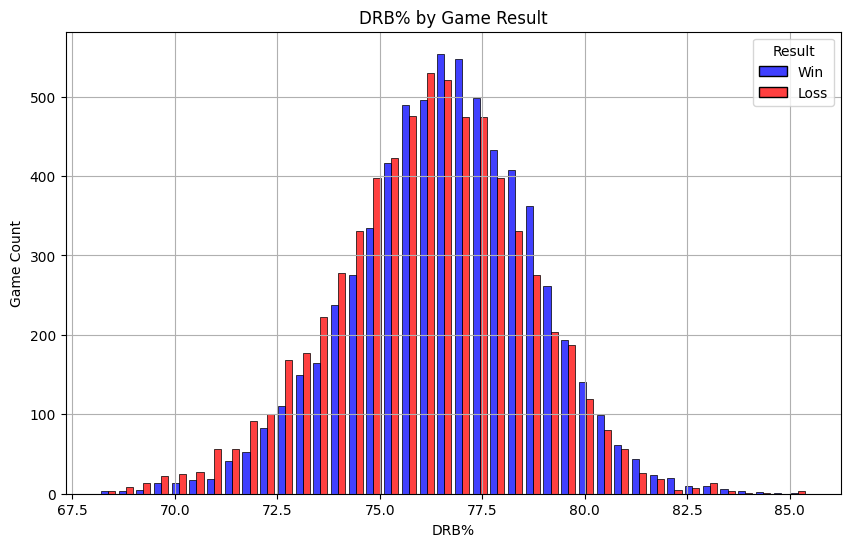

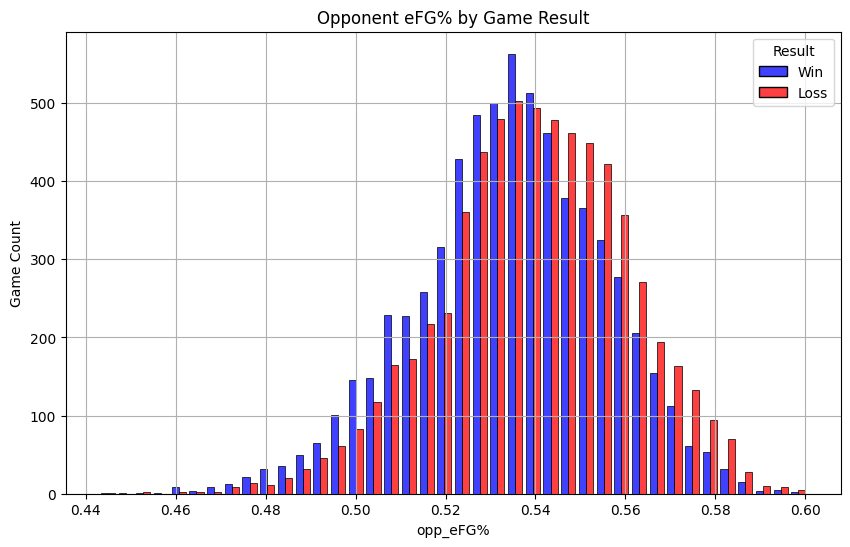

In [139]:
# TOV%
plot_grouped_histogram(data_copy, metric_col_x="TOV%.x", metric_col_y="TOV%.y", bins=40,
    x_label="TOV%", title="TOV% by Game Result")

# opp_TOV
plot_grouped_histogram(data_copy, metric_col_x="opp_TOV%.x", metric_col_y="opp_TOV%.y", bins=40,
    x_label="Opponent TOV%", title=" Opponent TOV% by Game Result")

# ORB%
plot_grouped_histogram(data_copy, metric_col_x="ORB%.x", metric_col_y="ORB%.y", bins=40,
    x_label="ORB%", title="ORB% by Game Result")

# DRB%
plot_grouped_histogram(data_copy, metric_col_x="DRB%.x", metric_col_y="DRB%.y", bins=40,
    x_label="DRB%", title="DRB% by Game Result")

# Opp_eFG%
plot_grouped_histogram(data_copy, metric_col_x="opp_eFG%.x", metric_col_y="opp_eFG%.y", bins=40,
    x_label="opp_eFG%", title="Opponent eFG% by Game Result")

## b. Tables

In [96]:
def summarize_game_outcomes(data, status_col_base, result_col="result", status_labels=None, title=""):
    """
    Summarizes game outcomes (Wins/Losses) by a binary status (e.g., back_to_back, home).
    
    Parameters:
    - data: Original DataFrame with .x and .y columns
    - status_col_base: The base name of the status column (e.g., "back_to_back", "home")
    - result_col: The name of the result column (default: "result")
    - status_labels: Optional list of labels for index (e.g., ["Not B2B", "B2B"])
    - title: Optional title to print
    
    Returns:
    - Formatted DataFrame with Wins, Losses, Total Games, and Win Rate (%)
    """
    # Make a copy
    df = data.copy()
    df[f"{result_col}.y"] = 1 - df[result_col]  # ensure .y version of result exists
    
    # Create home.y
    df['home.y'] = 1 - df['home.x']  # Create home.y

    # Combine status and result columns for both teams
    combined_status = pd.concat([df[f"{status_col_base}.x"], df[f"{status_col_base}.y"]], ignore_index=True)
    combined_result = pd.concat([df[result_col], df[f"{result_col}.y"]], ignore_index=True)

    # Create contingency table
    table = pd.crosstab(combined_status, combined_result)

    # Rename rows and columns
    table.index = status_labels or ["Status 0", "Status 1"]
    table.columns = ["Losses", "Wins"]

    # Add totals and win rate
    table["Total Games"] = table["Wins"] + table["Losses"]
    table.loc["Total"] = table.sum(numeric_only=True)
    table.loc["Total", "Total Games"] = table.loc["Total", ["Losses", "Wins"]].sum()
    table["Win Rate (%)"] = (table["Wins"] / table["Total Games"] * 100).round(2)
    table.loc["Total", "Win Rate (%)"] = np.nan

    # Display
    if title:
        print(f"\n{title}\n")
    print(table)

    return table

### i. Back-to-back and home tables

In [97]:
btb_info = summarize_game_outcomes(data, status_col_base="back_to_back",
                                   status_labels=["Not Back-to-Back", "Back-to-Back"],
                                   title="Game Outcomes by Back-to-Back Status ")
print()
home_info = summarize_game_outcomes(data, status_col_base="home", status_labels=["Not Home", "Home"],
    title="Game Outcomes by Home Status")


Game Outcomes by Back-to-Back Status 

                  Losses   Wins  Total Games  Win Rate (%)
Not Back-to-Back    9566  10068        19634         51.28
Back-to-Back        2413   1911         4324         44.20
Total              11979  11979        23958           NaN


Game Outcomes by Home Status

          Losses   Wins  Total Games  Win Rate (%)
Not Home    6774   5205        11979         43.45
Home        5205   6774        11979         56.55
Total      11979  11979        23958           NaN


## Correlation of Variables

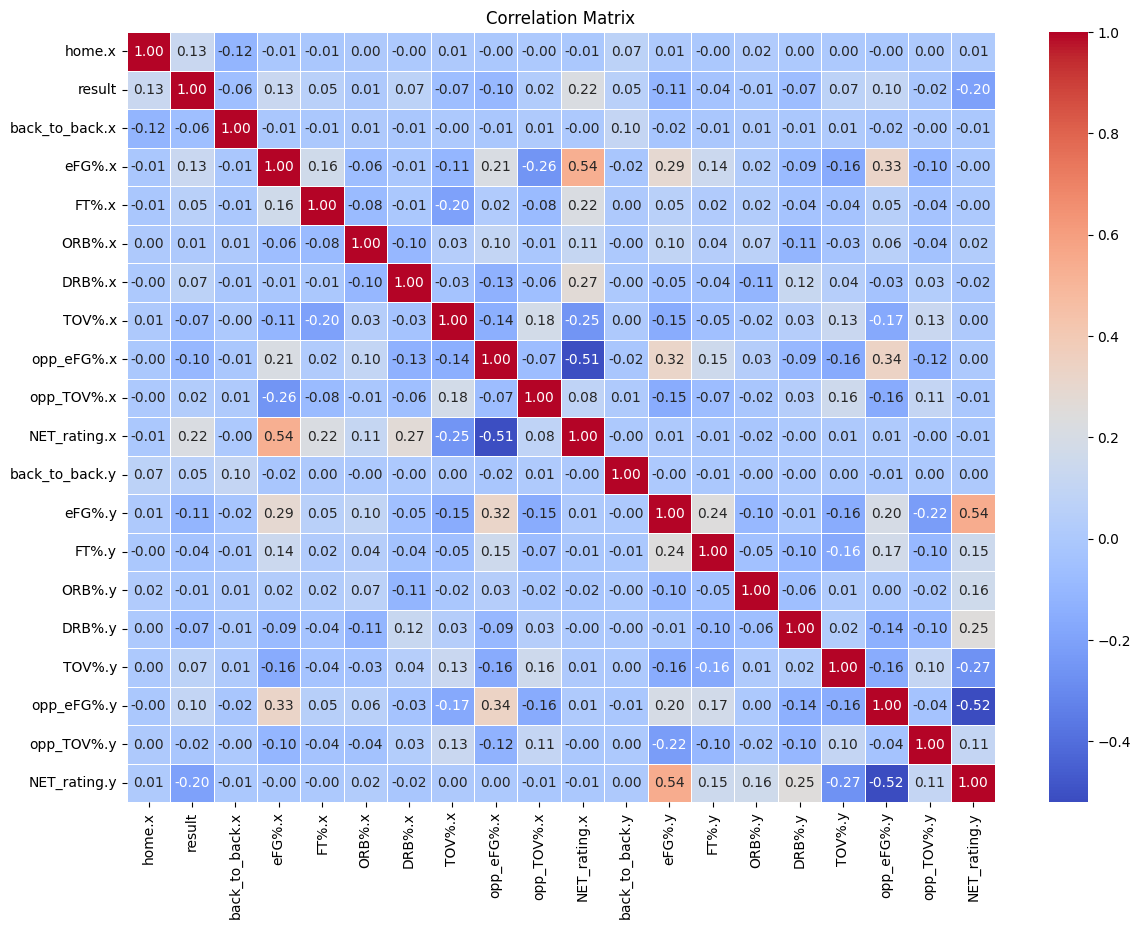

In [98]:
corr_data = data.copy()

corr_data = corr_data.drop(columns = ["season","game_number.x", "game_number.y","elo.x","elo.y","win%.x","win%.y"])

# Compute correlation matrix (numeric columns only)
corr = corr_data.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# 3. Data Preperation 

### Filter Data

In [17]:
# Remove games before 5th game of the season, and only focus on games after the 2020 season
data = data[data["game_number.x"] > 5]
data = data[data["season"] >= 2020]

In [18]:
print(len(data))
print(data[data["team.x"] == data["team.y"]])

6605
Empty DataFrame
Columns: [season, date, team.x, game_number.x, home.x, result, back_to_back.x, eFG%.x, FT%.x, ORB%.x, DRB%.x, TOV%.x, opp_eFG%.x, opp_TOV%.x, NET_rating.x, win%.x, elo.x, team.y, game_number.y, back_to_back.y, eFG%.y, FT%.y, ORB%.y, DRB%.y, TOV%.y, opp_eFG%.y, opp_TOV%.y, NET_rating.y, win%.y, elo.y]
Index: []

[0 rows x 30 columns]


### Remove features with very high correlation

In [19]:
# Net rating, win%, and elo are all highly correlated, elo more accurately trends a teams success during a season
data = data.drop(columns=['win%.x','win%.y','elo.x', 'elo.y'])

### Prepare Model Data and 2025 Data

In [20]:
# Define features and target
X = data.drop(columns=['result'])
y = data['result']

# Columns to exclude from modeling
exclude_cols = ['season', "date", "game_number.x", "team.x", 
                "game_number.y", "team.y"]

# Training data (2020–2024)
X_model = X[X["season"] < 2025].drop(columns=exclude_cols)
y_model = y[X["season"] < 2025]

# Holdout data (2025)
X_2025 = X[X["season"] == 2025].drop(columns=exclude_cols)
y_2025 = y[X["season"] == 2025]

# For analysis later (non-modeled features)
X_model_excluded = X[X["season"] < 2025][exclude_cols]
X_2025_excluded = X[X["season"] == 2025][exclude_cols]

### Sort Data Chronologically

In [21]:
# Add target back to X_model for sorting purposes
X_model_full = X_model.copy()
X_model_full["result"] = y_model.values
X_model_full["season"] = X[X["season"] < 2025]["season"].values
X_model_full["game_number.x"] = X[X["season"] < 2025]["game_number.x"].values  # Sorting column

# Sort chronologically
X_model_sorted = X_model_full.sort_values(by=["season", "game_number.x"])
y_model_sorted = X_model_sorted["result"]
X_model_sorted = X_model_sorted.drop(columns=["result", "season", "game_number.x"])  # Drop sorting info

### Create 70-30 train test split

In [22]:
split_idx = int(0.7 * len(X_model_sorted))

X_train = X_model_sorted.iloc[:split_idx]
X_test = X_model_sorted.iloc[split_idx:]
y_train = y_model_sorted.iloc[:split_idx]
y_test = y_model_sorted.iloc[split_idx:]

# 4. Statistical modeling

## a) Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler


# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

# Create the logistic regression model
pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=0))
])

param_grid_logreg = [
    {'logreg__penalty': ['l2'], 'logreg__C': [0.01, 0.1, 1, 10, 100], 'logreg__solver': ['lbfgs', 'newton-cg', 'sag', 'newton-cholesky'], 'logreg__class_weight': [None, 'balanced']},
    {'logreg__penalty': ['l1'], 'logreg__C': [0.01, 0.1, 1, 10, 100], 'logreg__solver': ['liblinear', 'saga'], 'logreg__class_weight': [None, 'balanced']},
    {'logreg__penalty': ['l2'], 'logreg__C': [0.01, 0.1, 1, 10, 100], 'logreg__solver': ['liblinear', 'saga'], 'logreg__class_weight': [None, 'balanced']},
    {'logreg__penalty': ['elasticnet'], 'logreg__C': [0.01, 0.1, 1, 10, 100], 'logreg__solver': ['saga'], 'logreg__l1_ratio': [0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0], 'logreg__class_weight': [None, 'balanced']}
]

logreg_clf = GridSearchCV(pipe_logreg, param_grid_logreg, cv=tscv, n_jobs=-1, scoring='accuracy')
    
# Fit the model on the train set
logreg_clf.fit(X_train, y_train)

print("Best Parameters:", logreg_clf.best_params_)

Best Parameters: {'logreg__C': 0.1, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}


### Metrics and plots

In [24]:
# Import metrics
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             precision_score, recall_score, f1_score, log_loss)

In [25]:
def evaluate_model(clf, X_test, y_test, X_2025, y_2025):
    # Evaluate a trained model on test and 2025 datasets
    
    # Predict labels and probabilities
    preds_clf = clf.predict(X_test)
    preds_clf_2025 = clf.predict(X_2025)
    #probs_clf = clf.predict_proba(X_test)
    # probs_clf_2025 = clf.predict_proba(X_2025)

    print(f"The accuracy of the model on the test set was: {accuracy_score(y_test, preds_clf):.3f}")
    print(f"The accuracy of the model on the 2025 season was: {accuracy_score(y_2025, preds_clf_2025):.3f}")

    # --- Test Set Metrics ---
    print("\n===== Test Set Metrics =====")
    print(f"Accuracy: {accuracy_score(y_test, preds_clf):.3f}")
    print(f"Precision: {precision_score(y_test, preds_clf):.3f}")
    print(f"Recall: {recall_score(y_test, preds_clf):.3f}")
    print(f"F1 Score: {f1_score(y_test, preds_clf):.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, preds_clf))
    print("\nClassification Report:")
    print(classification_report(y_test, preds_clf))

    # --- 2025 Season Metrics ---
    print("\n===== 2025 Season Metrics =====")
    print(f"Accuracy: {accuracy_score(y_2025, preds_clf_2025):.3f}")
    print(f"Precision: {precision_score(y_2025, preds_clf_2025):.3f}")
    print(f"Recall: {recall_score(y_2025, preds_clf_2025):.3f}")
    print(f"F1 Score: {f1_score(y_2025, preds_clf_2025):.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_2025, preds_clf_2025))
    print("\nClassification Report:")
    print(classification_report(y_2025, preds_clf_2025))

    return preds_clf, preds_clf_2025 

In [26]:
preds_log, preds_log_2025 = evaluate_model(logreg_clf, X_test, y_test, X_2025, y_2025)

The accuracy of the model on the test set was: 0.646
The accuracy of the model on the 2025 season was: 0.685

===== Test Set Metrics =====
Accuracy: 0.646
Precision: 0.631
Recall: 0.649
F1 Score: 0.640
Confusion Matrix:
[[542 301]
 [278 515]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65       843
           1       0.63      0.65      0.64       793

    accuracy                           0.65      1636
   macro avg       0.65      0.65      0.65      1636
weighted avg       0.65      0.65      0.65      1636


===== 2025 Season Metrics =====
Accuracy: 0.685
Precision: 0.666
Recall: 0.668
F1 Score: 0.667
Confusion Matrix:
[[425 183]
 [181 365]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       608
           1       0.67      0.67      0.67       546

    accuracy                           0.68      1154
   macro avg       0.68    

### Feature Importance of Logistic Regression 

In [27]:
# Get best estimator from GridSearchCV
best_log_model = logreg_clf.best_estimator_

# Extract the logistic regression step from the pipeline
logreg_step = best_log_model.named_steps['logreg']

# Get the coefficients
coefficients = logreg_step.coef_[0]

# Combine with feature names
feature_names = X_train.columns
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficient
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("Best feature coefficients for the Logistic Regression Model\n")
print(coef_df_sorted)

Best feature coefficients for the Logistic Regression Model

           Feature  Coefficient  Abs_Coefficient
18    NET_rating.y    -0.336418         0.336418
0           home.x     0.248862         0.248862
9     NET_rating.x     0.225007         0.225007
2           eFG%.x     0.212992         0.212992
1   back_to_back.x    -0.114964         0.114964
6           TOV%.x    -0.111321         0.111321
5           DRB%.x     0.102875         0.102875
15          TOV%.y     0.098938         0.098938
11          eFG%.y    -0.097269         0.097269
7       opp_eFG%.x    -0.076614         0.076614
8       opp_TOV%.x     0.074735         0.074735
14          DRB%.y    -0.067589         0.067589
10  back_to_back.y     0.060167         0.060167
13          ORB%.y     0.055897         0.055897
12           FT%.y    -0.052888         0.052888
16      opp_eFG%.y     0.042796         0.042796
17      opp_TOV%.y    -0.031225         0.031225
3            FT%.x     0.008601         0.008601
4       

### ROC-AUC curve

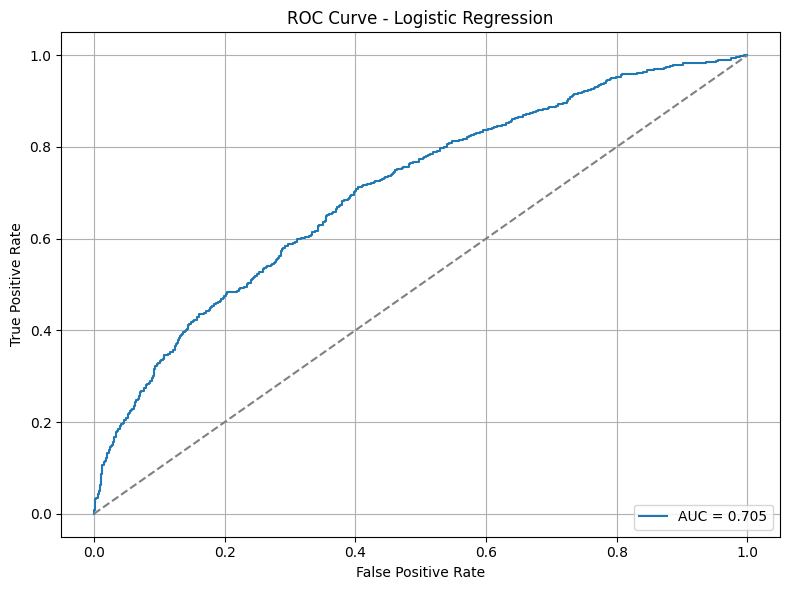

In [28]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, roc_auc_score

# Get predicted probabilities for the positive class
probs = logreg_clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc_score = roc_auc_score(y_test, probs)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

## b) Support Vector Machine Classifier (SVC)

In [29]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

# Initialize pipeline for SVC model
pipe_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=42))
])

# Define a simpler parameter grid for SVM
param_grid_svc = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__degree':[3,4,6,7,9],
    'svc__gamma': ['scale', 0.01, 0.1],
}

# Run the grid search
svc_clf = GridSearchCV(pipe_svc, param_grid_svc, 
                             cv=tscv, n_jobs=-1, 
                             scoring='accuracy')

# Fit the model with the best paramaters
svc_clf.fit(X_train, y_train)

# Find the predictions for the test set and 2025
preds_SCV = svc_clf.predict(X_test)
preds_SVC_2025 = svc_clf.predict(X_2025)

# Best model cross validation score
print("Best Parameters:", svc_clf.best_params_)

Best Parameters: {'svc__C': 0.1, 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'sigmoid'}


### Metrics and plots: SVC

In [30]:
preds_SCV, preds_SVC_2025 = evaluate_model(svc_clf, X_test, y_test, X_2025, y_2025)

The accuracy of the model on the test set was: 0.637
The accuracy of the model on the 2025 season was: 0.696

===== Test Set Metrics =====
Accuracy: 0.637
Precision: 0.629
Recall: 0.610
F1 Score: 0.620
Confusion Matrix:
[[558 285]
 [309 484]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       843
           1       0.63      0.61      0.62       793

    accuracy                           0.64      1636
   macro avg       0.64      0.64      0.64      1636
weighted avg       0.64      0.64      0.64      1636


===== 2025 Season Metrics =====
Accuracy: 0.696
Precision: 0.690
Recall: 0.648
F1 Score: 0.669
Confusion Matrix:
[[449 159]
 [192 354]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       608
           1       0.69      0.65      0.67       546

    accuracy                           0.70      1154
   macro avg       0.70    

### Feature Importantce

In [104]:
from sklearn.inspection import permutation_importance

# Get the best SVC model from the pipeline
best_svc = svc_clf.best_estimator_

# Compute permutation importance on the test set
perm_importance = permutation_importance(best_svc, X_test, y_test, scoring='accuracy', n_repeats=30, random_state=42)

# Build DataFrame of results
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values(by='Importance', ascending=False)

print(feature_importance.head(10))

           Feature  Importance       Std
0           home.x    0.013142  0.005961
9     NET_rating.x    0.011491  0.007859
18    NET_rating.y    0.007885  0.006423
1   back_to_back.x    0.006683  0.004620
7       opp_eFG%.x    0.000346  0.003442
13          ORB%.y    0.000061  0.001896
17      opp_TOV%.y   -0.000204  0.003170
5           DRB%.x   -0.000244  0.004662
3            FT%.x   -0.000407  0.001954
2           eFG%.x   -0.000937  0.005877


## c) Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest pipeline
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_depth': [None, 10, 20],
    'rf__class_weight': [None, 'balanced']
}

# Perform Grid Search with Cross-Validation
rf_clf = RandomizedSearchCV(pipe_rf, param_grid_rf, n_iter=50, cv=tscv, n_jobs=-1)

# Fit the model with the best paramaters
rf_clf.fit(X_train, y_train)

# Find the predictions for the test set and 2025
preds_RF = rf_clf.predict(X_test)
preds_RF_2025 = rf_clf.predict(X_2025)

# Best model cross validation score
print("Best Parameters:", rf_clf.best_params_)

Best Parameters: {'rf__n_estimators': 100, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 4, 'rf__max_features': 'sqrt', 'rf__max_depth': 10, 'rf__class_weight': None}


In [32]:
preds_RF, preds_RF_2025 = evaluate_model(rf_clf, X_test, y_test, X_2025, y_2025)

The accuracy of the model on the test set was: 0.617
The accuracy of the model on the 2025 season was: 0.648

===== Test Set Metrics =====
Accuracy: 0.617
Precision: 0.601
Recall: 0.620
F1 Score: 0.611
Confusion Matrix:
[[517 326]
 [301 492]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.61      0.62       843
           1       0.60      0.62      0.61       793

    accuracy                           0.62      1636
   macro avg       0.62      0.62      0.62      1636
weighted avg       0.62      0.62      0.62      1636


===== 2025 Season Metrics =====
Accuracy: 0.648
Precision: 0.627
Recall: 0.632
F1 Score: 0.630
Confusion Matrix:
[[403 205]
 [201 345]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.66      0.67       608
           1       0.63      0.63      0.63       546

    accuracy                           0.65      1154
   macro avg       0.65    

### Feature Importance: Random Forest Model

Feature Importances for the Random Forest Model:

           Feature  Importance
18    NET_rating.y    0.102571
9     NET_rating.x    0.102304
2           eFG%.x    0.078577
11          eFG%.y    0.066418
16      opp_eFG%.y    0.058761
12           FT%.y    0.058671
7       opp_eFG%.x    0.055187
5           DRB%.x    0.054333
6           TOV%.x    0.052243
15          TOV%.y    0.052176
13          ORB%.y    0.051402
14          DRB%.y    0.050128
17      opp_TOV%.y    0.048379
8       opp_TOV%.x    0.046131
3            FT%.x    0.045890
4           ORB%.x    0.043585
0           home.x    0.024134
1   back_to_back.x    0.005468
10  back_to_back.y    0.003641


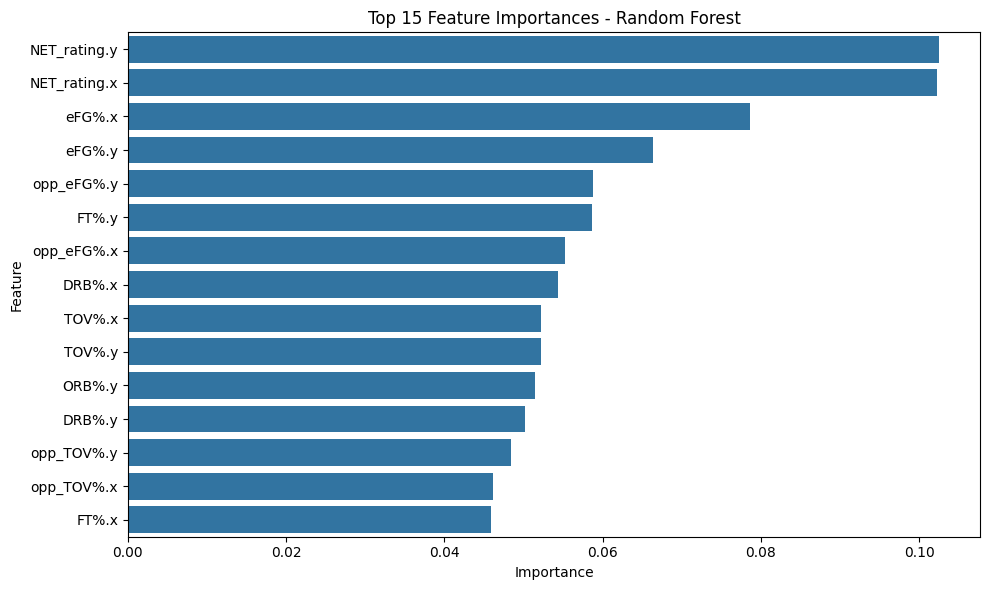

In [33]:
# Get the best estimator from GridSearchCV
best_rf_model = rf_clf.best_estimator_

# Extract rf step from pipeline
rf_step = best_rf_model.named_steps['rf']

# Feature importances
importances = rf_step.feature_importances_

# Combine with feature names
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Display top features
print("Feature Importances for the Random Forest Model:\n")
print(importances_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances_df.head(15), x='Importance', y='Feature')
plt.title('Top 15 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

### ROC-AUC curve

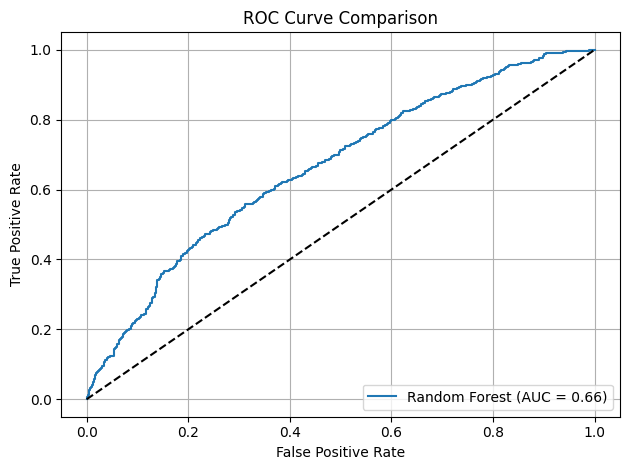

In [34]:
rf_probs = rf_clf.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# Plot random line
plt.plot([0, 1], [0, 1], 'k--')

# Labeling
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

## d) XGBoost

In [35]:
from xgboost import XGBClassifier

# Initialize model
pipe_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(eval_metric='logloss'))
])

# Build paramater grid
param_grid_xgb = {
    "xgb__n_estimators": [100, 200],
    "xgb__max_depth": [3, 5, 6],
    "xgb__learning_rate": [0.01, 0.05],
    "xgb__reg_alpha": [0, 0.1, 1],
    "xgb__reg_lambda": [0, 0.1, 1],
    "xgb__subsample": [0.7, 1.0],
    "xgb__colsample_bytree": [0.7, 0.8, 1.0],
    "xgb__gamma": [0, 0.1]
}


# Perform Grid Search with Cross-Validation
xgb_clf = RandomizedSearchCV(pipe_xgb, param_grid_xgb, n_iter=50, cv=tscv, n_jobs=-1)

# Fit the model with the best paramaters
xgb_clf.fit(X_train, y_train)

# Find the predictions for the test set and 2025
preds_XGB = xgb_clf.predict(X_test)
preds_XGB_2025 = xgb_clf.predict(X_2025)

# Best model cross validation score
print("Best Parameters:", xgb_clf.best_params_)

Best Parameters: {'xgb__subsample': 0.7, 'xgb__reg_lambda': 0.1, 'xgb__reg_alpha': 0.1, 'xgb__n_estimators': 200, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0, 'xgb__colsample_bytree': 1.0}


### Metrics and plots: XGBoost

In [36]:
preds_XGB, preds_XGB_2025 = evaluate_model(xgb_clf, X_test, y_test, X_2025, y_2025)

The accuracy of the model on the test set was: 0.635
The accuracy of the model on the 2025 season was: 0.660

===== Test Set Metrics =====
Accuracy: 0.635
Precision: 0.621
Recall: 0.634
F1 Score: 0.628
Confusion Matrix:
[[536 307]
 [290 503]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.64      0.64       843
           1       0.62      0.63      0.63       793

    accuracy                           0.64      1636
   macro avg       0.63      0.64      0.63      1636
weighted avg       0.64      0.64      0.64      1636


===== 2025 Season Metrics =====
Accuracy: 0.660
Precision: 0.634
Recall: 0.668
F1 Score: 0.651
Confusion Matrix:
[[397 211]
 [181 365]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.65      0.67       608
           1       0.63      0.67      0.65       546

    accuracy                           0.66      1154
   macro avg       0.66    

### Feature Importance XGBoost model

Feature Importances from XGBoost:

           Feature  Importance
18    NET_rating.y    0.126408
9     NET_rating.x    0.111376
2           eFG%.x    0.072446
0           home.x    0.068581
13          ORB%.y    0.051033
11          eFG%.y    0.050104
12           FT%.y    0.049946
5           DRB%.x    0.044151
7       opp_eFG%.x    0.043406
15          TOV%.y    0.043188
1   back_to_back.x    0.042985
6           TOV%.x    0.042978
3            FT%.x    0.039645
14          DRB%.y    0.039262
8       opp_TOV%.x    0.038684
17      opp_TOV%.y    0.035249
4           ORB%.x    0.034426
16      opp_eFG%.y    0.033342
10  back_to_back.y    0.032789


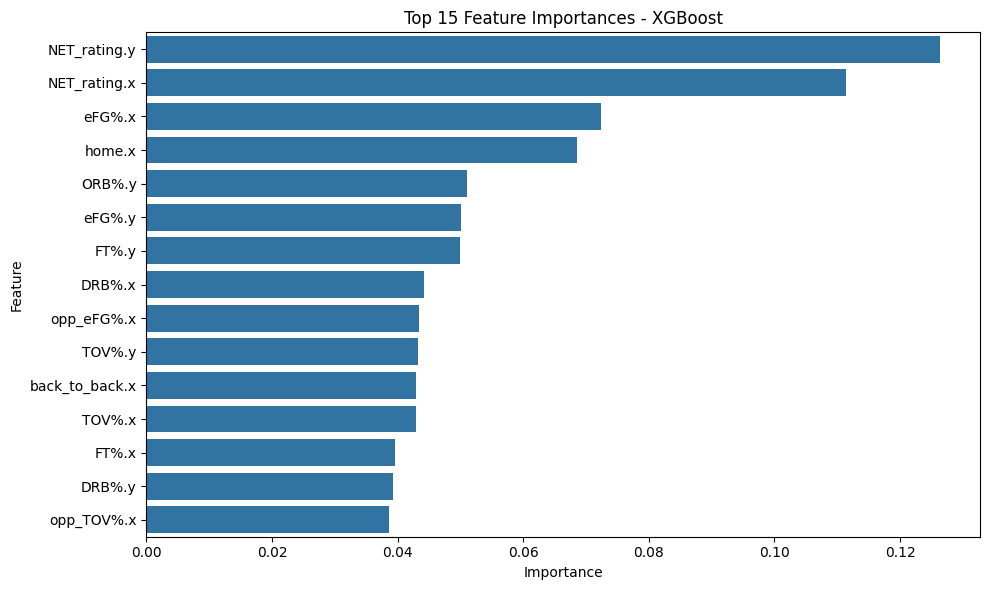

In [37]:
# Get the best estimator from GridSearchCV
best_XGB_model = xgb_clf.best_estimator_

# Extract XGB step from pipeline
xgb_step = best_XGB_model.named_steps['xgb']

# Feature importances
importances_XGB = xgb_step.feature_importances_

# Combine with feature names
importances_df_XGB = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances_XGB
}).sort_values(by="Importance", ascending=False)

# Display
print("Feature Importances from XGBoost:\n")
print(importances_df_XGB)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances_df_XGB.head(15), x='Importance', y='Feature')
plt.title('Top 15 Feature Importances - XGBoost')
plt.tight_layout()
plt.show()

### ROC-AUC curve

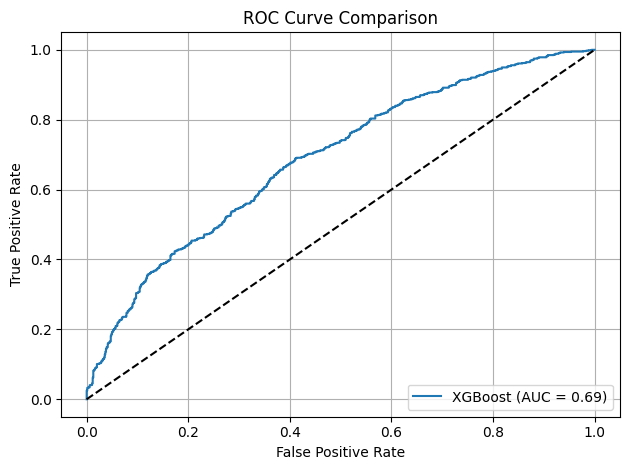

In [38]:
xgb_probs = xgb_clf.predict_proba(X_test)[:, 1]

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')

# Plot random line
plt.plot([0, 1], [0, 1], 'k--')

# Labeling
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

### Add predictions of best performing models into full 2025 dataset

In [39]:
data_2025 = X_2025_excluded.copy()

# Add results and predictions back into data_2025
data_2025["result"] = y_2025
data_2025["log_pred"] = preds_log_2025 # Logistic regression was the best overall performing model
data_2025["SVC_pred"] = preds_SVC_2025 # SVC was the second best performing model

# Add a variable that shows if the variable was correct or not
data_2025["correct_log"] = np.where(data_2025["team.x"].notnull(), 
    np.where(
        ((data_2025["team.x"] == data_2025["team.x"]) & (data_2025["log_pred"] == data_2025["result"])) |
        ((data_2025["team.y"] == data_2025["team.y"]) & (data_2025["log_pred"] == 0) & (data_2025["result"] == 0)),
        1, 0
    ), np.nan)

# SVC model correct from .x perspective
data_2025["correct_SVC"] = np.where(data_2025["team.x"].notnull(), 
    np.where(
        ((data_2025["team.x"] == data_2025["team.x"]) & (data_2025["SVC_pred"] == data_2025["result"])) |
        ((data_2025["team.y"] == data_2025["team.y"]) & (data_2025["SVC_pred"] == 0) & (data_2025["result"] == 0)),
        1, 0
    ), np.nan)


print(data_2025.columns)
print(data_2025.head()) # The predictions are correctly matched, they are predicting result.x

Index(['season', 'date', 'game_number.x', 'team.x', 'game_number.y', 'team.y',
       'result', 'log_pred', 'SVC_pred', 'correct_log', 'correct_SVC'],
      dtype='object')
       season        date  game_number.x team.x  game_number.y team.y  result  \
10820    2025  2024-11-01              6    ATL              5    SAC       0   
10821    2025  2024-11-01              6    BOS              5    CHO       1   
10822    2025  2024-11-01              6    BRK              6    CHI       1   
10823    2025  2024-11-01              6    ORL              6    CLE       0   
10826    2025  2024-11-01              6    NOP              6    IND       1   

       log_pred  SVC_pred  correct_log  correct_SVC  
10820         0         0          1.0          1.0  
10821         1         1          1.0          1.0  
10822         1         1          1.0          1.0  
10823         0         0          1.0          1.0  
10826         0         1          0.0          1.0  


# 5. Analysis of Results

In this section, we will take a deeper dive in analyzing the predictions of the highest performing models

### Dataframe of model accuracies

In [102]:
model_accuracies = {'Model': ['Logistic Regression', 'Support Vector Machine', 'Random Forest', 'XGBoost'],
        'Test Accuracy': [0.646, 0.637, 0.617, 0.635],
        '2025 Accuracy': [0.685, 0.696, 0.648, 0.660]}
temp_df = pd.DataFrame(model_accuracies)


print(temp_df)

                    Model  Test Accuracy  2025 Accuracy
0     Logistic Regression          0.646          0.685
1  Support Vector Machine          0.637          0.696
2           Random Forest          0.617          0.648
3                 XGBoost          0.635          0.660


### What percentage of times did the models pick the same result

In [40]:
# Count total number of rows
count_rows = len(data_2025)
print(f"The total number of rows in the 2025 dataset is: {count_rows}")

# Count same predictions between the two chosen models
count_same = (data_2025["log_pred"] == data_2025["SVC_pred"]).sum()
print(f"The percentage of the time that the two models predicted the same outcome is: {round(count_same / count_rows,5)}")

The total number of rows in the 2025 dataset is: 1154
The percentage of the time that the two models predicted the same outcome is: 0.9662


## Find model accuracies for each team

In [41]:
teams = ["ATL", "BOS", "BRK", "CHO", "CHI", "CLE", 
         "DAL", "DEN", "DET", "GSW", "HOU", "IND", 
         "LAC", "LAL", "MEM", "MIA", "MIL", "MIN",
         "NOP", "NYK", "OKC", "ORL", "PHI", "PHO", 
         "POR", "SAC", "SAS", "TOR", "UTA", "WAS"]

accuracies = []

for team in teams:
    subset = data_2025[(data_2025["team.x"] == team) | (data_2025["team.y"] == team)]
    wins = (((subset["team.x"] == team) & (subset["result"] == 1)) |
        ((subset["team.y"] == team) & (subset["result"] == 0))).sum()
    log_acc = subset["correct_log"].mean()
    svc_acc = subset["correct_SVC"].mean()
    
    accuracies.append({
        "team": team,
        "games_played": len(subset),
        "games_won": wins,
        "log_accuracy": round(log_acc, 4),
        "svc_accuracy": round(svc_acc, 4)
    })

accuracy_df = pd.DataFrame(accuracies).sort_values("games_won")
print(accuracy_df)

   team  games_played  games_won  log_accuracy  svc_accuracy
29  WAS            77         16        0.7403        0.7662
3   CHO            78         17        0.6923        0.6923
28  UTA            77         17        0.7662        0.7662
18  NOP            77         19        0.7662        0.7792
22  PHI            77         23        0.6883        0.7143
2   BRK            77         24        0.6753        0.6623
27  TOR            77         29        0.7273        0.7273
26  SAS            77         32        0.6883        0.6753
23  PHO            77         32        0.7532        0.7532
24  POR            76         34        0.6447        0.6711
15  MIA            77         34        0.6364        0.6364
4   CHI            77         36        0.6104        0.6234
6   DAL            77         36        0.6494        0.6494
25  SAC            78         38        0.5769        0.6026
21  ORL            77         38        0.6883        0.7013
0   ATL            77   

## Accuracy plots

In [140]:
median_gamesWON = accuracy_df["games_won"].median()
LQR_gamesWON = np.percentile(accuracy_df["games_won"], 25)
RQR_gamesWON = np.percentile(accuracy_df["games_won"], 75)

### Logistic Regression Accuracy vs Team Wins

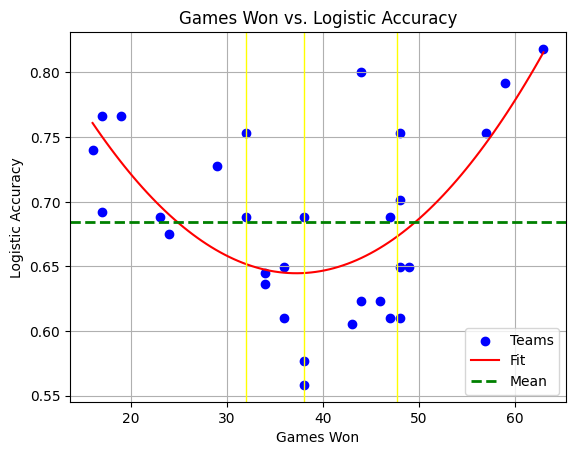

Accuracy of Logistic regression model is: 0.68467
Left quartile of games won is: 32.0
Median of games won is: 38.0
Right quartile of games won is: 47.75


In [141]:
# Segment the two vectors into x and y values
x = accuracy_df["games_won"]
y = accuracy_df["log_accuracy"]

# Plot the data points
plt.scatter(x, y, label="Teams", color ="blue")

# Fit a 2nd-degree polynomial (quadratic)
coeffs = np.polyfit(x, y, deg=2)
poly_eqn = np.poly1d(coeffs)

# Find smooth x values for curve
x_curve = np.linspace(x.min(), x.max(), 100)
y_curve = poly_eqn(x_curve)

# Plot the fitted curve
plt.plot(x_curve, y_curve, color='red', label='Fit')

# Plot accuracy of Logistic model
plt.axhline(y= y.mean(), color='green', linestyle='--', linewidth=2, label='Mean')

# Plot IQR of games won
plt.axvline(x = median_gamesWON, color='yellow', linestyle='-', linewidth=1) # Median     # TAKE OUT
plt.axvline(x = LQR_gamesWON, color='yellow', linestyle='-', linewidth=1) # LQR           # TAKE OUT
plt.axvline(x = RQR_gamesWON, color='yellow', linestyle='-', linewidth=1) # LQR           # TAKE OUT

plt.xlabel("Games Won")
plt.ylabel("Logistic Accuracy")
plt.title("Games Won vs. Logistic Accuracy")
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

print(f"Accuracy of Logistic regression model is: {round(y.mean(),5)}") 
print(f"Left quartile of games won is: {LQR_gamesWON}") # TAKE OUT
print(f"Median of games won is: {median_gamesWON}") # TAKE OUT
print(f"Right quartile of games won is: {RQR_gamesWON}") # TAKE OUT

### Support Vector Classifier vs Team Wins

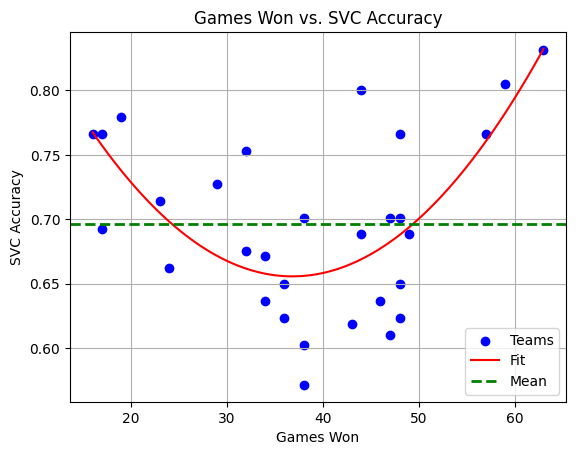

Accuracy of SVC model is: 0.69593


In [142]:
# Segment the two vectors into x and y values
x = accuracy_df["games_won"]
y = accuracy_df["svc_accuracy"]

# Plot the data points
plt.scatter(x, y, label="Teams", color ="blue")

# Fit a 2nd-degree polynomial (quadratic)
coeffs = np.polyfit(x, y, deg=2)
poly_eqn = np.poly1d(coeffs)

# Find smooth x values for curve
x_curve = np.linspace(x.min(), x.max(), 100)
y_curve = poly_eqn(x_curve)

# Plot the fitted curve
plt.plot(x_curve, y_curve, color='red', label='Fit')

# Plot accuracy of SVC model
plt.axhline(y= y.mean(), color='green', linestyle='--', linewidth=2, label='Mean')

plt.xlabel("Games Won")
plt.ylabel("SVC Accuracy")
plt.title("Games Won vs. SVC Accuracy")
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

print(f"Accuracy of SVC model is: {round(y.mean(),5)}")

### Finding the teams that the model performed the worst on

In [143]:
accuracy_df = pd.DataFrame(accuracies).sort_values("log_accuracy")
print(f"4 teams with lowest Log accuracy: \n{accuracy_df[:4]}\n\n")

accuracy_df = pd.DataFrame(accuracies).sort_values("svc_accuracy")
print(f"4 teams with lowest SVC accuracy: \n{accuracy_df[:4]}")

4 teams with lowest Log accuracy: 
   team  games_played  games_won  log_accuracy  svc_accuracy
0   ATL            77         38        0.5584        0.5714
25  SAC            78         38        0.5769        0.6026
8   DET            76         43        0.6053        0.6184
4   CHI            77         36        0.6104        0.6234


4 teams with lowest SVC accuracy: 
   team  games_played  games_won  log_accuracy  svc_accuracy
0   ATL            77         38        0.5584        0.5714
25  SAC            78         38        0.5769        0.6026
13  LAL            77         47        0.6104        0.6104
8   DET            76         43        0.6053        0.6184


### Precision and Recall of Individual Teams

In [111]:
def precisionAndRecall(data, tm):
    TP = 0
    TN = 0 
    FP = 0 
    FN = 0
    
    for i in range(len(data)):
        row = data.iloc[i]

        # Team is home (team.x)
        if row["team.x"] == tm:
            actual = row["result"]
            pred = row["SVC_pred"] # Change to log_pred to see results for logisitc regression
            
            if actual == 1 and pred == 1:
                TP += 1
            elif actual == 1 and pred == 0:
                FN += 1
            elif actual == 0 and pred == 1:
                FP += 1
            elif actual == 0 and pred == 0:
                TN += 1

        # Team is away (team.y)
        elif row["team.y"] == tm:
            # For away team, flip actual/pred because result is from home perspective
            actual = 0 if row["result"] == 0 else 1  # 0: away win, 1: away loss
            pred   = 0 if row["SVC_pred"] == 0 else 1 # Change to log_pred to see results for logisitc regression

            if actual == 0 and pred == 0:
                TP += 1
            elif actual == 0 and pred == 1:
                FN += 1
            elif actual == 1 and pred == 0:
                FP += 1
            elif actual == 1 and pred == 1:
                TN += 1

    # Precision/Recall for predicting wins
    precision_wins = TP / (TP + FP) if TP + FP != 0 else 0
    recall_wins    = TP / (TP + FN) if TP + FN != 0 else 0

    # Precision/Recall for predicting losses (from the TN perspective)
    precision_losses = TN / (TN + FN) if TN + FN != 0 else 0
    recall_losses    = TN / (TN + FP) if TN + FP != 0 else 0

    # Print confusion matrix
    print(f"\nConfusion Matrix for {tm}:")
    print("                 Predicted loss     Predicted win")
    print(f"Actual loss       |     {TN:4}          {FP:4}")
    print(f"Actual win        |     {FN:4}          {TP:4}")

    print(f"\nPrecision (predicting wins):  {precision_wins:.4f}")
    print(f"Recall    (predicting wins):  {recall_wins:.4f}")
    print(f"Precision (predicting losses): {precision_losses:.4f}")
    print(f"Recall    (predicting losses): {recall_losses:.4f}")

    return 

### Data used in report

In [123]:
precisionAndRecall(data_2025, "OKC")
print()
precisionAndRecall(data_2025, "UTA")
print()
precisionAndRecall(data_2025, "ORL")
print()
precisionAndRecall(data_2025, "PHO")


Confusion Matrix for OKC:
                 Predicted loss     Predicted win
Actual loss       |        1            13
Actual win        |        0            63

Precision (predicting wins):  0.8289
Recall    (predicting wins):  1.0000
Precision (predicting losses): 1.0000
Recall    (predicting losses): 0.0714


Confusion Matrix for UTA:
                 Predicted loss     Predicted win
Actual loss       |       55             5
Actual win        |       13             4

Precision (predicting wins):  0.4444
Recall    (predicting wins):  0.2353
Precision (predicting losses): 0.8088
Recall    (predicting losses): 0.9167


Confusion Matrix for ORL:
                 Predicted loss     Predicted win
Actual loss       |       29            10
Actual win        |       13            25

Precision (predicting wins):  0.7143
Recall    (predicting wins):  0.6579
Precision (predicting losses): 0.6905
Recall    (predicting losses): 0.7436


Confusion Matrix for PHO:
                 Predicted l

### Other teams

In [146]:
precisionAndRecall(data_2025, "SAC")
precisionAndRecall(data_2025, "IND")
precisionAndRecall(data_2025, "MIA")
precisionAndRecall(data_2025, "MIN")
precisionAndRecall(data_2025, "ATL")
precisionAndRecall(data_2025, "WAS")
precisionAndRecall(data_2025, "CHO")
precisionAndRecall(data_2025, "CLE")


Confusion Matrix for SAC:
                 Predicted loss     Predicted win
Actual loss       |       17            23
Actual win        |        8            30

Precision (predicting wins):  0.5660
Recall    (predicting wins):  0.7895
Precision (predicting losses): 0.6800
Recall    (predicting losses): 0.4250

Confusion Matrix for IND:
                 Predicted loss     Predicted win
Actual loss       |       14            15
Actual win        |       12            36

Precision (predicting wins):  0.7059
Recall    (predicting wins):  0.7500
Precision (predicting losses): 0.5385
Recall    (predicting losses): 0.4828

Confusion Matrix for MIA:
                 Predicted loss     Predicted win
Actual loss       |       26            17
Actual win        |       11            23

Precision (predicting wins):  0.5750
Recall    (predicting wins):  0.6765
Precision (predicting losses): 0.7027
Recall    (predicting losses): 0.6047

Confusion Matrix for MIN:
                 Predicted loss

### Other Plots

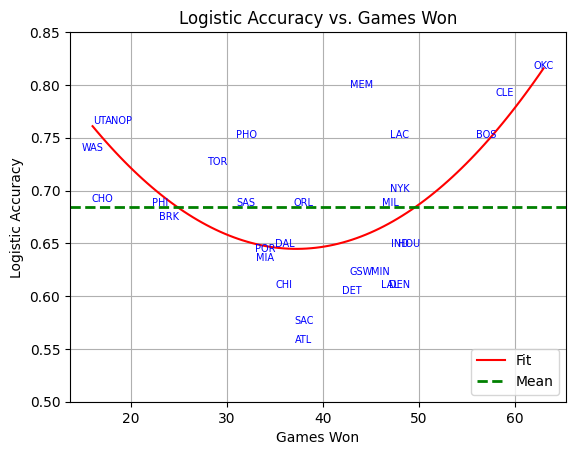

Accuracy of LOG model is: 0.68467


In [59]:
# Segment the two vectors into x and y values
x = accuracy_df["games_won"]
y = accuracy_df["log_accuracy"]

# Plot the data points
for i in range(len(accuracy_df)):
    plt.text(
        accuracy_df["games_won"].iloc[i],
        accuracy_df["log_accuracy"].iloc[i],
        accuracy_df["team"].iloc[i],
        fontsize=7,
        ha='center',
        va='center',
        color = "blue"
    )
# Fit a 2nd-degree polynomial (quadratic)
coeffs = np.polyfit(x, y, deg=2)
poly_eqn = np.poly1d(coeffs)

# Find smooth x values for curve
x_curve = np.linspace(x.min(), x.max(), 100)
y_curve = poly_eqn(x_curve)

# Plot the fitted curve
plt.plot(x_curve, y_curve, color='red', label='Fit')

# Plot accuracy of SVC model
plt.axhline(y= y.mean(), color='green', linestyle='--', linewidth=2, label='Mean')

# Set y-axis limits
plt.ylim(0.5, 0.85)

plt.xlabel("Games Won")
plt.ylabel("Logistic Accuracy")
plt.title("Logistic Accuracy vs. Games Won")
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

print(f"Accuracy of LOG model is: {round(y.mean(),5)}")

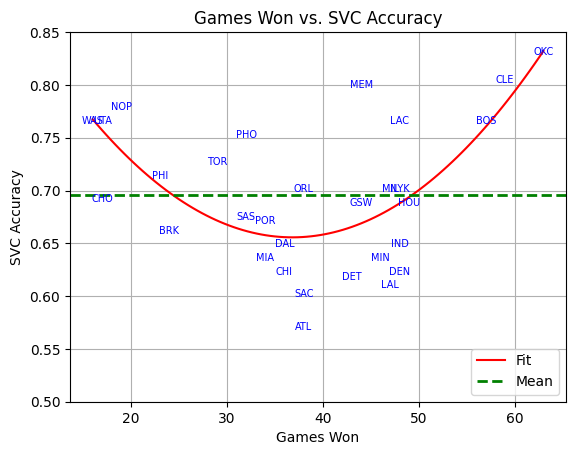

Accuracy of SVC model is: 0.69593


In [60]:
# Segment the two vectors into x and y values
x = accuracy_df["games_won"]
y = accuracy_df["svc_accuracy"]

# Plot the data points
for i in range(len(accuracy_df)):
    plt.text(
        accuracy_df["games_won"].iloc[i],
        accuracy_df["svc_accuracy"].iloc[i],
        accuracy_df["team"].iloc[i],
        fontsize=7,
        ha='center',
        va='center',
        color = "blue"
    )
# Fit a 2nd-degree polynomial (quadratic)
coeffs = np.polyfit(x, y, deg=2)
poly_eqn = np.poly1d(coeffs)

# Find smooth x values for curve
x_curve = np.linspace(x.min(), x.max(), 100)
y_curve = poly_eqn(x_curve)

# Plot the fitted curve
plt.plot(x_curve, y_curve, color='red', label='Fit')

# Plot accuracy of SVC model
plt.axhline(y= y.mean(), color='green', linestyle='--', linewidth=2, label='Mean')

# Set y-axis limits
plt.ylim(0.5, 0.85)

plt.xlabel("Games Won")
plt.ylabel("SVC Accuracy")
plt.title("Games Won vs. SVC Accuracy")
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

print(f"Accuracy of SVC model is: {round(y.mean(),5)}")